<a href="https://colab.research.google.com/github/franco-rey/Capstone/blob/main/ATC_UW_Deep_Learning_Forward_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Forward Looking Portfolio Optimization
**Authors**:
Wanchaloem "Omzin" Wunkaew

Franco Carlos

Algorithmic Trading Club, University of Washington, Seattle


Contact: leegarap[at]uw.edu



For educational purposes only

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from cvxopt import matrix,solvers
solvers.options['show_progress'] = False

### Data Preparation
We will use MSFT, JNJ, JPM,XOM stock prices from 2011 to 2020.

In [ ]:
#["MSFT", "JNJ", "JPM", "XOM"]

In [ ]:
stock_prices = np.load("./example_stocks.npy")

Text(0.5, 1.0, 'stock prices (starting from 2011)')

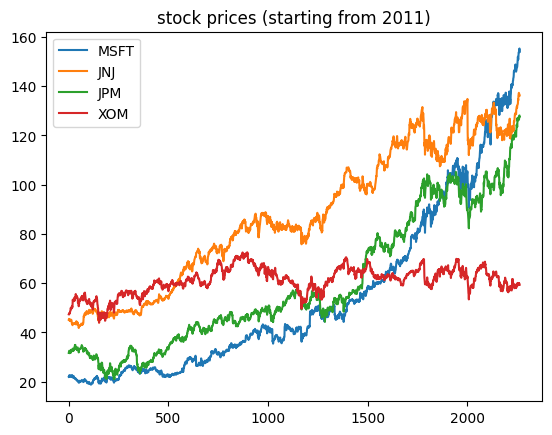

In [ ]:
plt.plot(stock_prices[:,0], label = "MSFT")
plt.plot(stock_prices[:,1], label = "JNJ")
plt.plot(stock_prices[:,2], label = "JPM")
plt.plot(stock_prices[:,3], label = "XOM")
plt.legend()
plt.title("stock prices (starting from 2011)")

### Return
Return is how much the investment changed in each time step.

There are many ways to compute returns. The simplest one is to divide the change in stock price by the price in the previous time step.

In finanical economics, they calculate something called **log return**, which is approximately equal to the above one, when the different change is close to 0.

In [ ]:
MSFT_return = np.log(stock_prices[1:,0]) - np.log(stock_prices[:-1,0])
JNJ_return = np.log(stock_prices[1:,1]) - np.log(stock_prices[:-1,1])
JPM_return = np.log(stock_prices[1:,2]) - np.log(stock_prices[:-1,2])
XOM_return = np.log(stock_prices[1:,3]) - np.log(stock_prices[:-1,3])
mean_return = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)

Text(0.5, 1.0, 'stock daily log return (starting from 2011)')

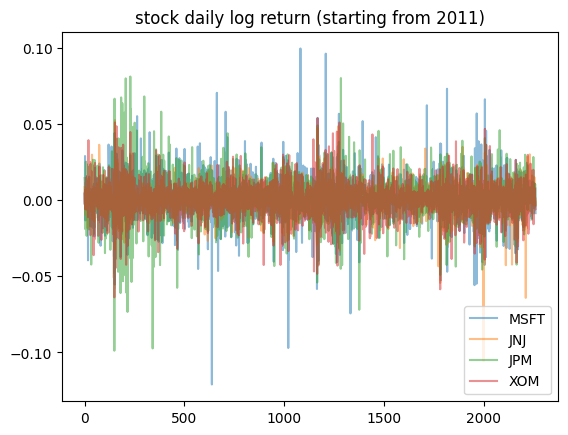

In [ ]:
plt.plot(MSFT_return, label = "MSFT",alpha = 0.5)
plt.plot(JNJ_return, label = "JNJ",alpha = 0.5)
plt.plot(JPM_return, label = "JPM",alpha = 0.5)
plt.plot(XOM_return, label = "XOM",alpha = 0.5)
plt.legend()
plt.title("stock daily log return (starting from 2011)")

### Mean (ie. Average)

The average of **the return** shows a value we expect the return would change in every time step.

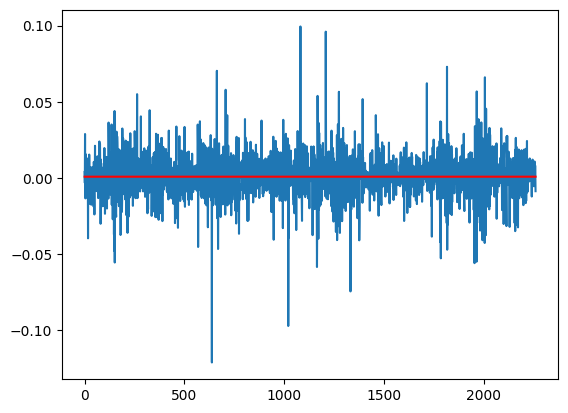

In [ ]:
plt.plot(MSFT_return, label = "MSFT")
plt.plot(np.arange(len(MSFT_return)),[np.mean(MSFT_return) for i in np.arange(len(MSFT_return))], color = "red")


### Variance and Standard Deviation

Variance is a value showing how likely the actual returns deviate from their means.
Std is the square root of the variance


In traditional financial econometric (at least 30 years ago), they frequently assume that the variance (and std) is **the risk** of investing in stock.
More variance, more likely the actual return deviate from the expected (average) return.

There are a lot of better methods to determine the risk of investment

In [ ]:
np.std(MSFT_return)

0.014357454129343184

In [ ]:
np.var(MSFT_return)

0.00020613648907619363

### Covariance and Correlation

**Covariance** of two returns is a value showing how one of the returns would change given another changed.

**Correlation** of two returns is a standardized covariance (lying between -1 and 1)

In the example below, I paired return on the same day of JNJ and MSFT. You can see that when the return of MSFT increase, the return of JNJ also increases

So, the return of MSFT and JNJ are positively correlated


Text(0.5, 1.0, 'JNJ return vs MSFT return')

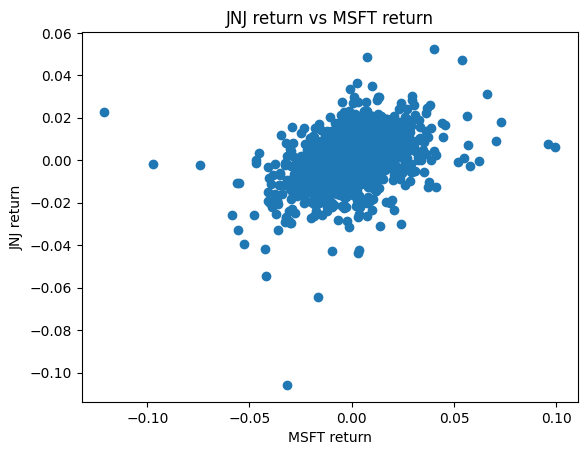

In [ ]:
plt.scatter(MSFT_return, JNJ_return)
plt.xlabel("MSFT return")
plt.ylabel("JNJ return")
plt.title("JNJ return vs MSFT return")

### Computing correlation

In [ ]:
MSFT_return = np.log(stock_prices[1:,0]) - np.log(stock_prices[:-1,0])
JNJ_return = np.log(stock_prices[1:,1]) - np.log(stock_prices[:-1,1])
JPM_return = np.log(stock_prices[1:,2]) - np.log(stock_prices[:-1,2])
XOM_return = np.log(stock_prices[1:,3]) - np.log(stock_prices[:-1,3])
mean_return = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)

In [ ]:
np.corrcoef([MSFT_return, JNJ_return, JPM_return, XOM_return])

array([[1.        , 0.39234081, 0.4697746 , 0.42715581],
       [0.39234081, 1.        , 0.43038597, 0.4638505 ],
       [0.4697746 , 0.43038597, 1.        , 0.54864345],
       [0.42715581, 0.4638505 , 0.54864345, 1.        ]])

In [ ]:
cov = np.cov([MSFT_return, JNJ_return, JPM_return, XOM_return])
cov

array([[2.06227660e-04, 5.42792797e-05, 1.03557211e-04, 7.19242114e-05],
       [5.42792797e-05, 9.28098911e-05, 6.36462173e-05, 5.23950786e-05],
       [1.03557211e-04, 6.36462173e-05, 2.35632246e-04, 9.87467686e-05],
       [7.19242114e-05, 5.23950786e-05, 9.87467686e-05, 1.37477196e-04]])

## Portfolio Optimization

Now, we have two values **mean** (the expected return, expected profit/loss) and **variance** (risk,bacially).

We want to invest in four stocks mentioned above to **get maximum return with minimum risk**.

We have to allocate (to weight) the investment in each stocks, so we get maximum return but minimum variance.

There are many ways to find such weights, eg. Brute Force, random, genetic algorithm.

I use **Quadratic Programming** in this example

In [ ]:
# Invest in each stock evenly
w = np.array([0.25,0.25,0.25,0.25])
portfolio_return = w @ mean_return.T
portfolio_variance = w.reshape([-1,4]) @ cov @ w.reshape([-1,4]).T
print("portfolio return: ", portfolio_return)
print("portfolio variance:", portfolio_variance.squeeze())

portfolio return:  0.0005164154744425496
portfolio variance: 9.75777828520713e-05


In [ ]:
# invest 50% in msft, 30% in JAJ, 10% in ...
w = np.array([0.50,0.30,0.10,0.10])
portfolio_return = w @ mean_return.T
portfolio_variance = w.reshape([-1,4]) @ cov @ w.reshape([-1,4]).T
print("portfolio return: ", portfolio_return)
print("portfolio variance:", portfolio_variance.squeeze())

portfolio return:  0.0006486308301801434
portfolio variance: 0.00010641023880362792


Just random 10000 allocation and find the one that gave highest return but smallest risk

In [ ]:
random_weight = (np.random.rand( 4 * 10000)).reshape([-1,4])
random_weight = np.divide(random_weight.T,np.sum(random_weight,axis = 1)).T

In [ ]:
portfolio_return = random_weight @ mean_return.T
portfolio_variance = []
for i in range(len(random_weight )):
    portfolio_variance.append((random_weight[i,:].reshape([-1,4]) @ cov @ random_weight[i,:].reshape([-1,4]).T).squeeze())
portfolio_variance = np.array(portfolio_variance)

Text(0.5, 1.0, 'Mean-Variance')

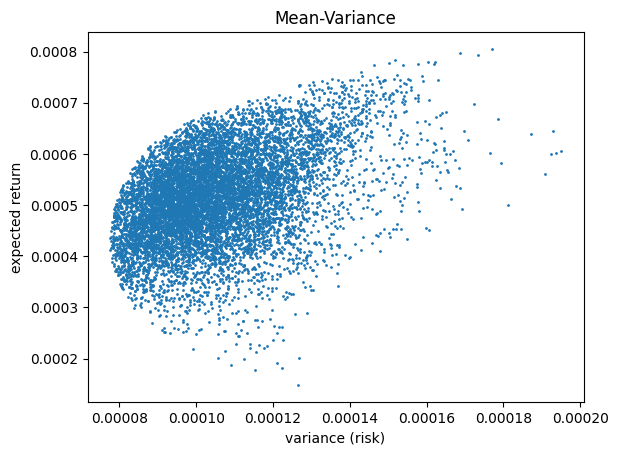

In [ ]:
plt.scatter(portfolio_variance, portfolio_return,s = 1)
plt.xlabel("variance (risk)")
plt.ylabel("expected return")
plt.title("Mean-Variance")

In [ ]:
risk_level = 0.3
P = matrix( cov,tc = 'd')
q = matrix(-risk_level * mean_return, tc = 'd')
G = matrix(-np.eye(4))
h = matrix(np.zeros(4))
A = matrix(np.ones([4]).reshape([-1,4]), tc = 'd')
b = matrix(1.0, tc = 'd')
sol = solvers.qp(P, q, G, h, A, b)
optimal_weight = np.array(sol['x'])
w = optimal_weight.T
optimal_return = w @ mean_return.T
optimal_variance = w.reshape([-1,4]) @ cov @ w.reshape([-1,4]).T

In [ ]:
print("optimal weight:", np.round(w * 100))

optimal weight: [[77. 19.  4.  0.]]


Text(0.5, 1.0, 'Mean-Variance for random portfolio')

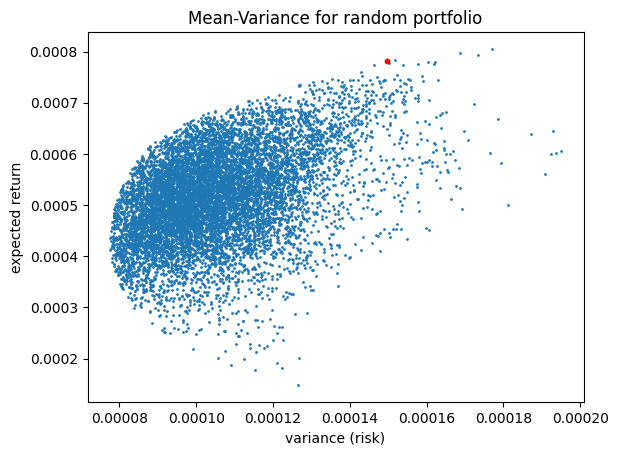

In [ ]:
plt.scatter(portfolio_variance, portfolio_return,s = 1)
plt.scatter(optimal_variance,optimal_return, color = 'red', s = 10)
plt.xlabel("variance (risk)")
plt.ylabel("expected return")
plt.title("Mean-Variance for random portfolio")

**Given an expected return we want to make in an investment, we can allocate the portfolio to get smallest risk. Basically, the optimal portfolio given the return we want is on the boundary of the plot above**


**However, consider the boundary, we can see that if we want more return we must take more risk**
So, how much risk you can endure is also an input to portfolio optmimzation

### Portfolio Optimization Strategy

1. We compute the optimal weights for each stock using 40-days back in the past
2. Every 7 days, we rebalance the portfolio using 40-day data.


No slippage, No transaction, No short


Test on stock data from July 2019 til the end of the year

In [ ]:
test_stock = np.load("./test_stock.npy")

Text(0.5, 1.0, 'stock prices (starting from July 2019)')

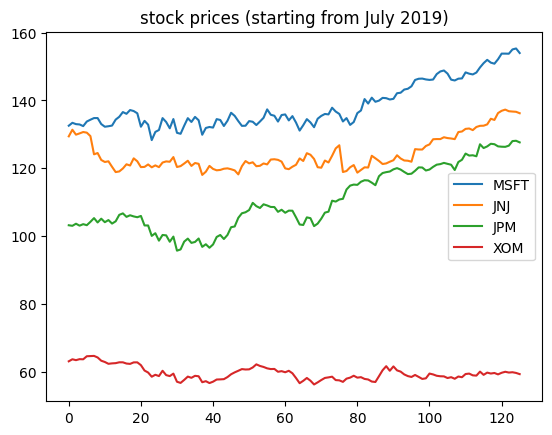

In [ ]:
plt.plot(test_stock[:,0], label = "MSFT")
plt.plot(test_stock[:,1], label = "JNJ")
plt.plot(test_stock[:,2], label = "JPM")
plt.plot(test_stock[:,3], label = "XOM")
plt.legend()
plt.title("stock prices (starting from July 2019)")





#### Backward-Looking Portfolio Optimization
We use stock prices in the past to optimize a portfolio.

In [ ]:
reb_interval = 7
start_date = 10
start_balance = 1
risk_level = 0.08

In [ ]:
bw_data = test_stock[:40,:]
MSFT_return = np.log(bw_data [1:,0]) - np.log(bw_data[:-1,0])
JNJ_return = np.log(bw_data [1:,1]) - np.log(bw_data[:-1,1])
JPM_return = np.log(bw_data[1:,2]) - np.log(bw_data[:-1,2])
XOM_return = np.log(bw_data [1:,3]) - np.log(bw_data [:-1,3])
mean_return = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)
MSFT_mean,JNJ_mean, JPM_mean, XOM_mean = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)

Text(0.5, 1.0, 'stock daily log return (starting from July 2019)')

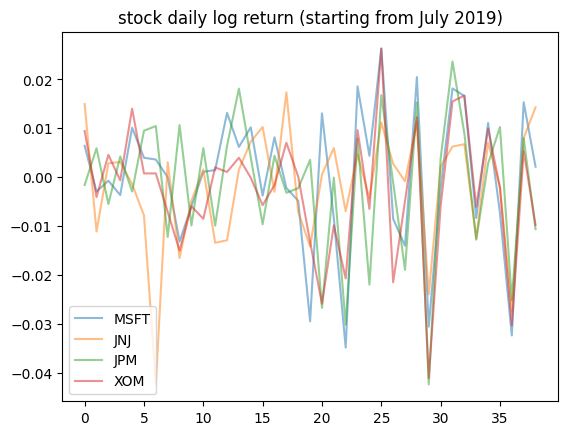

In [ ]:
plt.plot(MSFT_return, label = "MSFT",alpha = 0.5)
plt.plot(JNJ_return, label = "JNJ",alpha = 0.5)
plt.plot(JPM_return, label = "JPM",alpha = 0.5)
plt.plot(XOM_return, label = "XOM",alpha = 0.5)
plt.legend()
plt.title("stock daily log return (starting from July 2019)")

In [ ]:
bw_balance = start_balance
balance_log = []
# Compute the initial balance
bw_data = test_stock[:40,:]
MSFT_return = np.log(bw_data [1:,0]) - np.log(bw_data[:-1,0])
JNJ_return = np.log(bw_data [1:,1]) - np.log(bw_data[:-1,1])
JPM_return = np.log(bw_data[1:,2]) - np.log(bw_data[:-1,2])
XOM_return = np.log(bw_data [1:,3]) - np.log(bw_data [:-1,3])
mean_return = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)
MSFT_mean,JNJ_mean, JPM_mean, XOM_mean = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)
cov = np.cov([MSFT_return, JNJ_return, JPM_return, XOM_return])

P = matrix( cov,tc = 'd')
q = matrix(-risk_level * mean_return, tc = 'd')
G = matrix(-np.eye(4))
h = matrix(np.zeros(4))
A = matrix(np.ones([4]).reshape([-1,4]), tc = 'd')
b = matrix(1.0, tc = 'd')
sol = solvers.qp(P, q, G, h, A, b)
optimal_weight = np.array(sol['x'])
w = optimal_weight.T
print("Investment in [MSFT, JNJ, JPM, XOM] %:",np.around(bw_balance * w.squeeze() * 100))
print("Sum balance:", np.sum(bw_balance * w.squeeze()))

balance_log.append(bw_balance * w.squeeze())

Investment in [MSFT, JNJ, JPM, XOM] %: [100.   0.   0.   0.]
Sum balance: 1.0


In [ ]:
for i in range(1,len(test_stock)-40):
    today_balance = balance_log[-1]
    if i % reb_interval == 0:
        w = np.array([0,0,1,0])

        bw_balance = np.sum(balance_log[-1])
        bw_data = test_stock[i:40+i,:]
        MSFT_return = np.log(bw_data [1:,0]) - np.log(bw_data[:-1,0])
        JNJ_return = np.log(bw_data [1:,1]) - np.log(bw_data[:-1,1])
        JPM_return = np.log(bw_data[1:,2]) - np.log(bw_data[:-1,2])
        XOM_return = np.log(bw_data [1:,3]) - np.log(bw_data [:-1,3])
        mean_return = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)
        MSFT_mean,JNJ_mean, JPM_mean, XOM_mean = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)
        cov = np.cov([MSFT_return, JNJ_return, JPM_return, XOM_return])
        P = matrix(cov,tc = 'd')
        q = matrix(-risk_level * mean_return, tc = 'd')
        G = matrix(-np.eye(4))
        h = matrix(np.zeros(4))
        A = matrix(np.ones([4]).reshape([-1,4]), tc = 'd')
        b = matrix(1.0, tc = 'd')
        sol = solvers.qp(P, q, G, h, A, b)
        optimal_weight = np.array(sol['x'])
        w = optimal_weight.T
        print("rebalance: ", int(i/reb_interval))
        print("Investment in [MSFT, JNJ, JPM, XOM]:",np.round(w * 100))
        print("Sum balance:", np.sum(bw_balance * w.squeeze()))
        today_balance = bw_balance * w.squeeze()

    stock_ret = np.log(test_stock[40+i, :]) - np.log(test_stock[40+i-1, :])
    balance_log.append(today_balance * np.exp(stock_ret))

rebalance:  1
Investment in [MSFT, JNJ, JPM, XOM]: [[63. 34.  3.  0.]]
Sum balance: 1.026098803541973
rebalance:  2
Investment in [MSFT, JNJ, JPM, XOM]: [[ 0. 78. 22.  0.]]
Sum balance: 1.0236876871419958
rebalance:  3
Investment in [MSFT, JNJ, JPM, XOM]: [[ 2. 44. 54.  0.]]
Sum balance: 1.0157425385177636
rebalance:  4
Investment in [MSFT, JNJ, JPM, XOM]: [[ 0. 23. 77.  0.]]
Sum balance: 1.0219854786566518
rebalance:  5
Investment in [MSFT, JNJ, JPM, XOM]: [[  0.   0. 100.   0.]]
Sum balance: 1.0619458482585395
rebalance:  6
Investment in [MSFT, JNJ, JPM, XOM]: [[  0.   0. 100.   0.]]
Sum balance: 1.1182544339551335
rebalance:  7
Investment in [MSFT, JNJ, JPM, XOM]: [[  0.   0. 100.   0.]]
Sum balance: 1.1454945786436292
rebalance:  8
Investment in [MSFT, JNJ, JPM, XOM]: [[14.  0. 86.  0.]]
Sum balance: 1.1410869812692939
rebalance:  9
Investment in [MSFT, JNJ, JPM, XOM]: [[  0.   0. 100.   0.]]
Sum balance: 1.167103044668155
rebalance:  10
Investment in [MSFT, JNJ, JPM, XOM]: [[  0. 

Text(0.5, 1.0, 'Growth when investing one dallars in each asset')

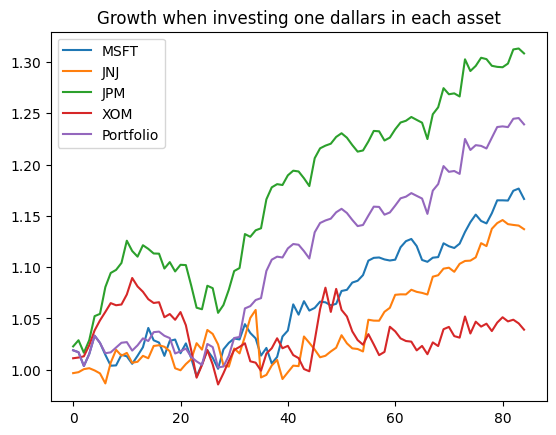

In [ ]:
bw_data = test_stock[40:,:]
MSFT_return = np.log(bw_data [1:,0]) - np.log(bw_data[:-1,0])
JNJ_return = np.log(bw_data [1:,1]) - np.log(bw_data[:-1,1])
JPM_return = np.log(bw_data[1:,2]) - np.log(bw_data[:-1,2])
XOM_return = np.log(bw_data [1:,3]) - np.log(bw_data [:-1,3])
portfolio_return = np.log(np.sum(np.array(balance_log),axis = 1)[1:]) - np.log(np.sum(np.array(balance_log),axis = 1)[:-1])

plt.plot(np.cumprod(np.exp(MSFT_return)),label = "MSFT")
plt.plot(np.cumprod(np.exp(JNJ_return)), label = "JNJ")
plt.plot(np.cumprod(np.exp(JPM_return)), label = "JPM")
plt.plot(np.cumprod(np.exp(XOM_return)), label = "XOM")
plt.plot(np.cumprod(np.exp(portfolio_return)), label = "Portfolio")
plt.legend()
plt.title("Growth when investing one dallars in each asset")


Text(0.5, 1.0, 'Portfolio if invest \\$ 1000000')

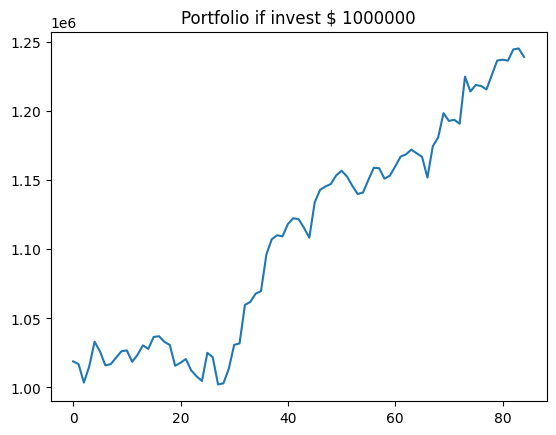

In [ ]:
plt.plot(1000000*np.cumprod(np.exp(portfolio_return)), label = "Portfolio")
plt.title("Portfolio if invest \$ 1000000")

## Deep Learning

### Problems of Traditional Portfolio Optimization

The method I showed above was invented 70 years ago. There are a lot of problems with that method. But there are many methods invented to fix that problem.

One of the problems of that portfolio that it is backward-looking! That is, we use stock prices in the past and present to optimize the portfolio. In this meeting, we will forecast stock prices using machine learning and optimize portfolios using such the prediction.

Remark: I do not like this method.
### Machine Learning

Basically, we have a stock data in the past, and we want to predict the price of the stock in the future. we feed a computer the stock prices in the past and the stock prices in the future of the past (eg feed a stock price of stock in 2000 as input and stock price in 2001 as an output) Machine learning algorithm will fit the model to predict the stock prices in the future

### data preparation

In [ ]:
def create_dataset(stock_price, window_length = 20, shift = 1,valid_p = 0.1,test_p = 0.1):
    ltrain_index = int((1- test_p - valid_p) * len(stock_price))
    lvalid_index = int((1-test_p) * len(stock_price))
    X_train,Y_train,X_valid, Y_valid, X_test,Y_test = list(), list(), list(), list(), list(), list()
    i = 0
    while(i+window_length  + shift <  ltrain_index):
        X_train.append(stock_price[i:i+window_length])
        Y_train.append(stock_price[i+window_length:i+window_length+shift])
        i += 1

    while(i+window_length  + shift < lvalid_index):
        X_valid.append(stock_price[i:i+window_length])
        Y_valid.append(stock_price[i+window_length:i+window_length+shift])
        i += 1

    while(i+window_length  + shift < len(stock_prices)):
        X_test.append(stock_price[i:i+window_length])
        Y_test.append(stock_price[i+window_length:i+window_length+shift])
        i += 1
    return np.array(X_train), np.array(Y_train), np.array(X_valid), np.array(Y_valid), np.array(X_test), np.array(Y_test)

def create_datasets(stock_prices, window_length = 20, shift = 1, valid_p = 0.1, test_p = 0.1):
    X_train,Y_train,X_valid, Y_valid, X_test,Y_test = list(), list(), list(), list(), list(), list()
    for stock_price in stock_prices:
        x_train, y_train, x_valid, y_valid, x_test, y_test = create_dataset(stock_price, window_length, shift, valid_p, test_p)
        X_train.append(x_train)
        Y_train.append(y_train)
        X_valid.append(x_valid)
        Y_valid.append(y_valid)
        X_test.append(x_test)
        Y_test.append(y_test)
    return np.concatenate(X_train),np.concatenate(Y_train),np.concatenate(X_valid), np.concatenate(Y_valid), np.concatenate(X_test), np.concatenate(Y_test)

In [ ]:
X_train,Y_train, X_valid, Y_valid, X_test,Y_test = create_datasets([stock_prices[:,0], stock_prices[:,1], stock_prices[:,2], stock_prices[:,3]], window_length = 40, shift = 20 ,test_p = 0.001)

In [ ]:
X_train

array([[21.96444702, 22.05080032, 21.98015404, ..., 20.96508789,
        20.98877335, 20.65712166],
       [22.05080032, 21.98015404, 22.6238575 , ..., 20.98877335,
        20.65712166, 20.59394264],
       [21.98015404, 22.6238575 , 22.45115471, ..., 20.65712166,
        20.59394264, 20.68871117],
       ...,
       [64.29131317, 65.09011078, 66.12290955, ..., 55.94491577,
        56.18942642, 55.5618515 ],
       [65.09011078, 66.12290955, 65.87277222, ..., 56.18942642,
        55.5618515 , 55.5781517 ],
       [66.12290955, 65.87277222, 66.15518188, ..., 55.5618515 ,
        55.5781517 , 56.80072403]])

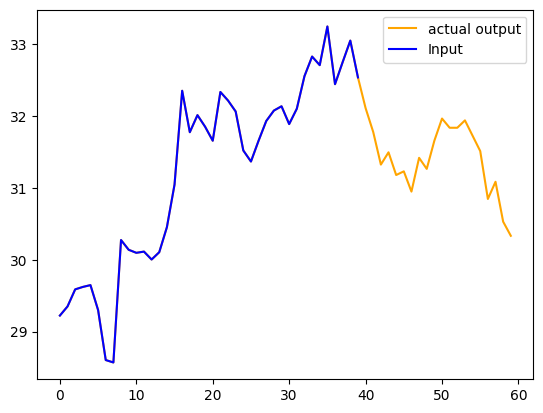

In [ ]:
index = 700
plt.plot(np.concatenate([X_train[index,:],Y_train[index,:] ]), color = "orange",label = "actual output")
plt.plot(X_train[index,:],color = "blue",label = "Input")
plt.legend()

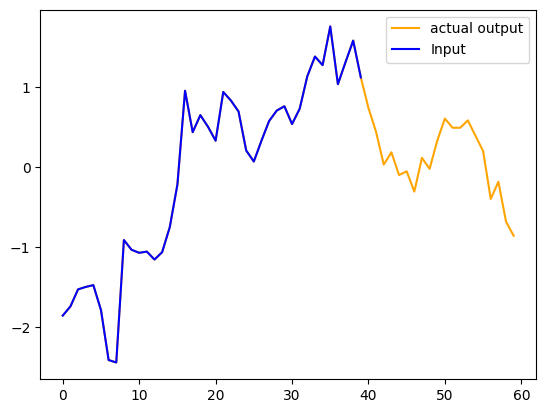

In [ ]:
mean_dat = np.mean(np.concatenate([X_train[index,:],Y_train[index] ]))
std_dat = np.std(np.concatenate([X_train[index,:],Y_train[index] ]))

plt.plot((np.concatenate([X_train[index,:],Y_train[index] ]) -mean_dat)/std_dat , color = "orange",label = "actual output")
plt.plot((X_train[index,:]-mean_dat)/std_dat,color = "blue",label = "Input")
plt.legend()

In [ ]:
dat = np.concatenate([X_train,Y_train],axis = 1)
mean = np.mean(dat, axis = 1)
std = np.std(dat, axis = 1)
for i in range(len(X_train)):
    X_train[i] = (X_train[i] - mean[i])/std[i]
    Y_train[i] = (Y_train[i] - mean[i])/std[i]

dat = np.concatenate([X_valid,Y_valid],axis = 1)
mean = np.mean(dat, axis = 1)
std = np.std(dat, axis = 1)
for i in range(len(X_valid)):
    X_valid[i] = (X_valid[i] - mean[i])/std[i]
    Y_valid[i] = (Y_valid[i] - mean[i])/std[i]

X_train = np.expand_dims(X_train,axis =2)
Y_train = np.expand_dims(Y_train,axis =2)
X_valid = np.expand_dims(X_valid,axis =2)
Y_valid = np.expand_dims(Y_valid,axis =2)

## Model

I use LSTM to predict stock prices

In [ ]:
train_layers = [
                tf.keras.layers.LSTM(64, return_sequences=True),
                tf.keras.layers.LSTM(64, return_sequences=True),
                tf.keras.layers.LSTM(32, return_sequences=False),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(20, activation= None)]

In [ ]:
model = tf.keras.Sequential(
    train_layers
)

# We use Adam Optimizater and use mean squared error as loss function here.
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError())

In [ ]:
#create check_point
cp_id = 0
while os.path.exists("./training_LSTM_"+str(cp_id)):
    cp_id += 1
checkpoint_path = "./training_LSTM_"+str(cp_id)+"/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=120)
history  = model.fit(X_train, Y_train, epochs=3, validation_data = (X_valid, Y_valid),callbacks=[es,cp_callback])

Epoch 1/3
247/247 [==============================] - ETA: 0s - loss: 0.4215
Epoch 1: saving model to ./training_LSTM_0/cp.ckpt
247/247 [==============================] - 20s 80ms/step - loss: 0.4215 - val_loss: 0.3882
Epoch 2/3
247/247 [==============================] - ETA: 0s - loss: 0.4000
Epoch 2: saving model to ./training_LSTM_0/cp.ckpt
247/247 [==============================] - 17s 71ms/step - loss: 0.4000 - val_loss: 0.3965
Epoch 3/3
247/247 [==============================] - ETA: 0s - loss: 0.3964
Epoch 3: saving model to ./training_LSTM_0/cp.ckpt
247/247 [==============================] - 18s 74ms/step - loss: 0.3964 - val_loss: 0.3833


In [ ]:
model.load_weights("./training_LSTM_0/cp.ckpt")

#### deep learning forward-looking portfolio optimization
we use stock prices in the past to optimize a portfolio

In [ ]:
reb_interval = 7
start_date = 10
start_balance = 1
risk_level = 0.08

In [ ]:
bw_data = test_stock[:40,:]
MSFT_return = np.log(bw_data [1:,0]) - np.log(bw_data[:-1,0])
JNJ_return = np.log(bw_data [1:,1]) - np.log(bw_data[:-1,1])
JPM_return = np.log(bw_data[1:,2]) - np.log(bw_data[:-1,2])
XOM_return = np.log(bw_data [1:,3]) - np.log(bw_data [:-1,3])
mean_return = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)
MSFT_mean,JNJ_mean, JPM_mean, XOM_mean = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)

In [ ]:
np.mean(test_stock[:40,:], axis = 0)

array([133.33577995, 122.75187073, 101.95890503,  60.97058477])

In [ ]:
def predict(input_prices):
    mean = np.mean(input_prices, axis = 0)
    std = np.std(input_prices, axis = 0)
    stock_prices = (input_prices - mean)/std

    msft_predict = model.predict(stock_prices[:,0].reshape([-1,40,1]),verbose = 0).squeeze()
    jnj_predict = model.predict(stock_prices[:,1].reshape([-1,40,1]),verbose = 0).squeeze()
    jpm_predict = model.predict(stock_prices[:,2].reshape([-1,40,1]),verbose = 0).squeeze()
    xom_predict = model.predict(stock_prices[:,3].reshape([-1,40,1]),verbose = 0).squeeze()

    return np.stack([msft_predict, jnj_predict,jpm_predict, xom_predict],axis = 1) * std + mean

Text(0.5, 1.0, 'stock prices (starting from July 2019) with predicted after vertical line')

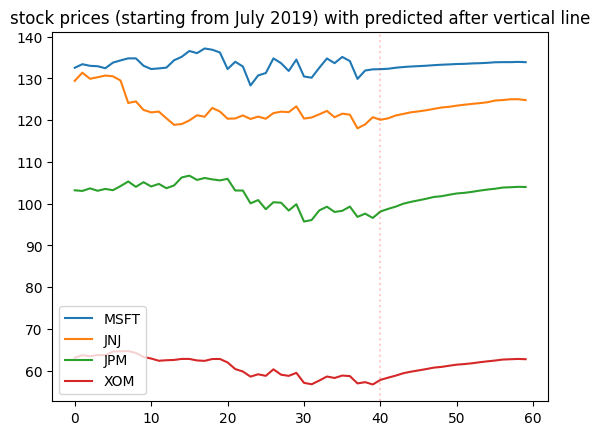

In [ ]:
predicted_prices = predict(test_stock[:40])
tp = np.vstack([test_stock[:40], predicted_prices])
plt.plot(tp[:,0], label = "MSFT")
plt.plot(tp[:,1], label = "JNJ")
plt.plot(tp[:,2], label = "JPM")
plt.plot(tp[:,3], label = "XOM")
plt.axvline(40,color = "red",alpha = 0.2,linestyle = "dotted")
plt.legend()
plt.title("stock prices (starting from July 2019) with predicted after vertical line")


In [ ]:
bw_balance = start_balance
fw_balance_log = []
# Compute the initial balance
bw_data = predict(test_stock[:40,:])

MSFT_return = np.log(bw_data [1:,0]) - np.log(bw_data[:-1,0])
JNJ_return = np.log(bw_data [1:,1]) - np.log(bw_data[:-1,1])
JPM_return = np.log(bw_data[1:,2]) - np.log(bw_data[:-1,2])
XOM_return = np.log(bw_data [1:,3]) - np.log(bw_data [:-1,3])
mean_return = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)
MSFT_mean,JNJ_mean, JPM_mean, XOM_mean = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)
cov = np.cov([MSFT_return, JNJ_return, JPM_return, XOM_return])

P = matrix( cov,tc = 'd')
q = matrix(-risk_level * mean_return, tc = 'd')
G = matrix(-np.eye(4))
h = matrix(np.zeros(4))
A = matrix(np.ones([4]).reshape([-1,4]), tc = 'd')
b = matrix(1.0, tc = 'd')
sol = solvers.qp(P, q, G, h, A, b)
optimal_weight = np.array(sol['x'])
w = optimal_weight.T
print("Investment in [MSFT, JNJ, JPM, XOM] %:",np.around(bw_balance * w.squeeze() * 100))
print("Sum balance:", np.sum(bw_balance * w.squeeze()))

fw_balance_log.append(bw_balance * w.squeeze())

Investment in [MSFT, JNJ, JPM, XOM] %: [  0.   0.   0. 100.]
Sum balance: 1.0


In [ ]:
for i in range(1,len(test_stock)-40):
    today_balance = fw_balance_log[-1]
    if i % reb_interval == 0:
        bw_balance = np.sum(fw_balance_log[-1])
        bw_data = predict(test_stock[i:40+i,:])
        MSFT_return = np.log(bw_data [1:,0]) - np.log(bw_data[:-1,0])
        JNJ_return = np.log(bw_data [1:,1]) - np.log(bw_data[:-1,1])
        JPM_return = np.log(bw_data[1:,2]) - np.log(bw_data[:-1,2])
        XOM_return = np.log(bw_data [1:,3]) - np.log(bw_data [:-1,3])
        mean_return = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)
        MSFT_mean,JNJ_mean, JPM_mean, XOM_mean = np.mean([MSFT_return, JNJ_return, JPM_return, XOM_return],axis = 1)
        cov = np.cov([MSFT_return, JNJ_return, JPM_return, XOM_return])
        P = matrix(cov,tc = 'd')
        q = matrix(-risk_level * mean_return, tc = 'd')
        G = matrix(-np.eye(4))
        h = matrix(np.zeros(4))
        A = matrix(np.ones([4]).reshape([-1,4]), tc = 'd')
        b = matrix(1.0, tc = 'd')
        sol = solvers.qp(P, q, G, h, A, b)
        optimal_weight = np.array(sol['x'])
        w = optimal_weight.T
        print("rebalance: ", int(i/reb_interval))
        print("Investment in [MSFT, JNJ, JPM, XOM]:",np.round(w * 100))
        print("Sum balance:", np.sum(bw_balance * w.squeeze()))
        today_balance = bw_balance * w.squeeze()

    stock_ret = np.log(test_stock[40+i, :]) - np.log(test_stock[40+i-1, :])
    fw_balance_log.append(today_balance * np.exp(stock_ret))

rebalance:  1
Investment in [MSFT, JNJ, JPM, XOM]: [[  0.   0.   0. 100.]]
Sum balance: 1.0480194816122388
rebalance:  2
Investment in [MSFT, JNJ, JPM, XOM]: [[  0. 100.   0.   0.]]
Sum balance: 1.0811097691485414
rebalance:  3
Investment in [MSFT, JNJ, JPM, XOM]: [[  0. 100.   0.   0.]]
Sum balance: 1.074274213086712
rebalance:  4
Investment in [MSFT, JNJ, JPM, XOM]: [[  0.   0.   0. 100.]]
Sum balance: 1.110199007976195
rebalance:  5
Investment in [MSFT, JNJ, JPM, XOM]: [[  0.   0.   0. 100.]]
Sum balance: 1.113627365749983
rebalance:  6
Investment in [MSFT, JNJ, JPM, XOM]: [[  0.   0.   0. 100.]]
Sum balance: 1.1302745567226675
rebalance:  7
Investment in [MSFT, JNJ, JPM, XOM]: [[  0. 100.   0.   0.]]
Sum balance: 1.1929464820748428
rebalance:  8
Investment in [MSFT, JNJ, JPM, XOM]: [[  0.   0.   0. 100.]]
Sum balance: 1.1978852765464496
rebalance:  9
Investment in [MSFT, JNJ, JPM, XOM]: [[  0.   0.   0. 100.]]
Sum balance: 1.2050584221210778
rebalance:  10
Investment in [MSFT, JNJ,

Text(0.5, 1.0, 'Portfolio and individual stock values over time')

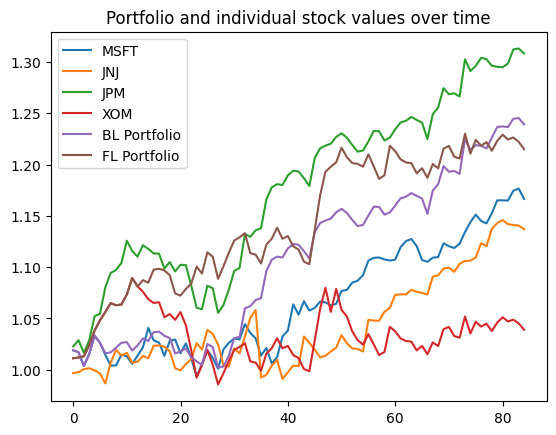

In [ ]:
bw_data = test_stock[40:,:]
MSFT_return = np.log(bw_data [1:,0]) - np.log(bw_data[:-1,0])
JNJ_return = np.log(bw_data [1:,1]) - np.log(bw_data[:-1,1])
JPM_return = np.log(bw_data[1:,2]) - np.log(bw_data[:-1,2])
XOM_return = np.log(bw_data [1:,3]) - np.log(bw_data [:-1,3])
bl_portfolio_return = np.log(np.sum(np.array(balance_log),axis = 1)[1:]) - np.log(np.sum(np.array(balance_log),axis = 1)[:-1])
fl_portfolio_return = np.log(np.sum(np.array(fw_balance_log),axis = 1)[1:]) - np.log(np.sum(np.array(fw_balance_log),axis = 1)[:-1])

plt.plot(np.cumprod(np.exp(MSFT_return)),label = "MSFT")
plt.plot(np.cumprod(np.exp(JNJ_return)), label = "JNJ")
plt.plot(np.cumprod(np.exp(JPM_return)), label = "JPM")
plt.plot(np.cumprod(np.exp(XOM_return)), label = "XOM")
plt.plot(np.cumprod(np.exp(bl_portfolio_return )), label = "BL Portfolio")
plt.plot(np.cumprod(np.exp(fl_portfolio_return )), label = "FL Portfolio")
plt.legend()
plt.title("Portfolio and individual stock values over time")


Text(0.5, 1.0, 'Portfolio if invest \\$ 1000000')

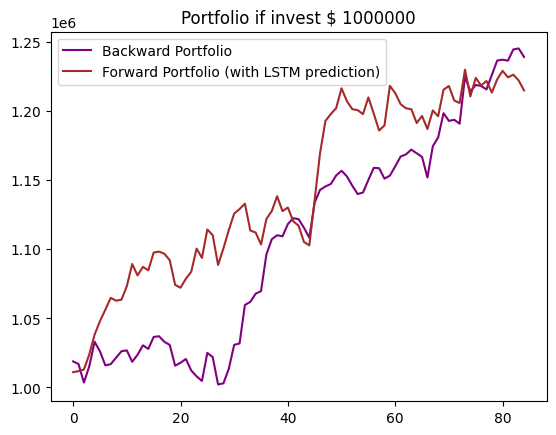

In [ ]:
plt.plot(1000000*np.cumprod(np.exp(bl_portfolio_return )), label = "Backward Portfolio",color ="purple")
plt.plot(1000000*np.cumprod(np.exp(fl_portfolio_return )), label = "Forward Portfolio (with LSTM prediction)",color= "brown")
plt.legend()
plt.title("Portfolio if invest \$ 1000000")